# Cluster Interpretation and Improvement
***

In this module I'll focus on understanding the champion type clusters I previously derived and hopefully improving them. I'll do this through a combination of techniques, including:

- VIF testing to eliminate features providing redundent information (ie infinite VIF values). This will not only improve interpretability but also lower the computational complexity of k-means and t-SNE algorithms.
- t-SNE to reduce the dimensionality of playerDF for each of the player position partitions in order to visually inspect the validity of the initial clusters and determine if 
- A helper function that will tell me which features had the strongest influence on determining clusters for each of the lane positions. This will help me understand what each cluster represents from a playstyle perspective **and**
    - <span style="color:gray">Alert me potential bias being introduced into the regression these clusters are being used in (ie if the clusters are being split too heavily on features I already know to be important in-game performance descriptors like tower kills and gspd, then I will need to impose new limits on the features being used for the clustering, so as to not be indirectly passing such information to the subsequent regression).</span>
- Edit and alter some of the features used for clustering based on domain knowledge and previous clustering results.
- Test regression performance of improved clusters.
- Attempt a second round of clustering on teamDF to derive team compositions as a feature to be used in subsequent regressions.

In [5]:
%store -r teamDF
%store -r norm_teamDF
%store -r playerDF
%store -r new_featuresDF

# first_cluster is a df of previous cluster results stored w/ 'gameid' and 'player' as multiindex
# containing features 'team' and 'cluster'
# first_clustDFs is a list of DF's tops, jungs, mids, adcs, and sups - the partitioned df's of a
# cleaned up playerDF w/o result or position features and including the first cluster results as
# a cluster feature
# k_players is a cleaned up copy of playerDF (fully NaN columns dropped, NaN row values imputed by mean or
# median depending on outlier concentration of feature).
    
%store -r first_cluster
%store -r first_clustDFs
%store -r k_players


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from scipy import stats
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Why VIF Test First?

It seems somewhat indirect to have all this clustering information done only to go back to VIF testing and repeating the k-means clustering before interpretion, however, the clusters as they currently exist are not as interprettable as I would like them to be. Because they were built with redundant features, that problem was passed on to the feature emphasis of the clusters.

Below is my helper function for evaluating the clusters. It takes one of the partitioned DF's, and returns all features where the clusters differ in their min and max values by more than the supplied 'spread' parameter of standard deviations.

In [25]:
def get_cluster_factors(df, spread = 1):
    dummies = [f for f in list(df) if 'champion_' in f]
    sd = df.std()
    g = df.drop(dummies, axis = 'columns').groupby('cluster').mean()
    big_factors = [(c, (max(g[c]) - min(g[c]))/sd[c]) for c in g if max(g[c]) - min(g[c]) >= spread*sd[c]]
    big_factors = [(b[0], float("{0:.3f}".format(b[1]))) for b in big_factors]
    return sorted(big_factors, reverse = True, key=lambda x: x[1])

get_cluster_factors(first_clustDFs[0], 2)

[('dmgtochamps', 4.385),
 ('totalgold', 3.33),
 ('dmgtochampsperminute', 3.311),
 ('goldspent', 3.261),
 ('gamelength', 2.645),
 ('minionkills', 2.524),
 ('wards', 2.45)]

dmgtochamps, dmgtochampsperminute, and gamelength are some of the most important features to distinguish between the clusters. But any one of those features can be perfectly predicted by the other two. This sort of relationship not only makes interpretting the difference between clusters harder, it makes understanding the scale of the differences more difficult as well.

So before trying to understand the derived clusters, I'll determine the redundant features and remove them.

### VIF Testing
***

This section is mostly a repeat of the VIF testing previously done on teamDF, but will now be performed on playerDF (or more specifically, on k_players, the copy of playerDF that already has NaN's taken care of. The reason for having to repeat this procedure is that playerDF is missing features that teamDF contains and vice-versa. Additionally, certain features in teamDF were averages or sums for features in playerDF, and thus may no longer contain redundent information in playerDF.

In [7]:
# create function to perform the VIF testing

def get_vif(df, regressors, response):
    # Where df is a dataframe, regressors is a list of strings representing columns
    # in df, and response is a string representing the outcome column in df.
    cols = "+".join(regressors)
    outcome, pred = dmatrices(response + ' ~' + cols, df, return_type='dataframe')
    vif = pd.DataFrame()
    vif["Variance Inflation Factor"] = [variance_inflation_factor(pred.values, i) for i in range(pred.shape[1])]
    vif["Regressor"] = pred.columns
    return vif.round(2).sort_values(by = 'Variance Inflation Factor', ascending = False )

In [26]:
# vif function can only handle numeric data. position, team, and champion can all be dropped.
# side can be dummified. I would like to preserve patchno information to help
# with clustering later, but I am also concerned about adding 34 features to DF because t-SNE
# can get out of control quickly as it has quadratic complexity. For now I will drop patchno
# as I'm getting some weird error in the vif function at a subsequent step based on the dummy
# columns and I can't seem to trace the source.

k_players.dtypes[:10]

patchno       category
side          category
position      category
team          category
champion      category
gamelength     float64
result           int64
k                int64
d                int64
a                int64
dtype: object

In [37]:
vif_playerDF = pd.get_dummies(k_players, columns = ['side'])
vif_playerDF.drop(['position','team','champion', 'patchno'], axis = 'columns', inplace = True)

In [41]:
regressors = list(set(list(vif_playerDF)) - set(['result']))
vif = get_vif(vif_playerDF, regressors, 'result')
print("VIF's greater than 10: ", sum(vif['Variance Inflation Factor'] > 10))
vif.head(15)

C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF's greater than 10:  38


Variance Inflation Factor    Regressor
73                        inf  oppgoldat15
8                         inf   elementals
33                        inf  waterdrakes
56                        inf    oppxpat10
55                        inf       gdat15
45                        inf      xpdat10
21                        inf  earthdrakes
11                        inf   firedrakes
14                        inf     goldat15
28                        inf    airdrakes
2                         inf       xpat10
20               2.522445e+07       gdat10
36               8.166307e+06     side_Red
12               2.418357e+06    side_Blue
5                2.594441e+05     goldat10

Start by removing oppxpat10, oppgoldat15, and oppgoldat10.

In [44]:
player_vif_inflators = ['result', 'oppxpat10', 'oppgoldat15', 'oppgoldat10']
regressors = list(set(list(vif_playerDF)) - set(player_vif_inflators))
vif = get_vif(vif_playerDF, regressors, 'result')
print("VIF's greater than 10: ", sum(vif['Variance Inflation Factor'] > 10))
vif.head(10)

# regressors = list(set(list(reg_teamDF)) - set(['result','elementals', 'k', 'd', 'ckpm', 'fbvictim', 'gdat10', 'gdat15', 'xpdat10']))

C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF's greater than 10:  31


Variance Inflation Factor     Regressor
21                        inf   earthdrakes
12                        inf     side_Blue
28                        inf     airdrakes
36                        inf      side_Red
8                         inf    elementals
33                        inf   waterdrakes
11                        inf    firedrakes
61                 132.650000   minionkills
67                 119.050000  monsterkills
50                 108.510000          cspm

Next I'll take out 'elementals' and 'side_Blue'.

In [45]:
player_vif_inflators = ['result', 'oppxpat10', 'oppgoldat15', 'oppgoldat10', 'elementals', 'side_Blue']
regressors = list(set(list(vif_playerDF)) - set(player_vif_inflators))
vif = get_vif(vif_playerDF, regressors, 'result')
print("VIF's greater than 10: ", sum(vif['Variance Inflation Factor'] > 10))
vif.head(10)

VIF's greater than 10:  25


Variance Inflation Factor              Regressor
0                      936.54              Intercept
59                     132.65            minionkills
65                     119.05           monsterkills
48                     108.51                   cspm
37                      68.44              totalgold
14                      65.86                    wpm
9                       62.64  monsterkillsownjungle
11                      55.88                  wards
3                       53.15            dmgtochamps
64                      51.79   dmgtochampsperminute

These no longer have infinite VIF's, but there are definitely features that still have multicolinear relationships that are perhaps not infinite due to imputing NaN's at an earlier stage of analysis.

I'll remove 'dmgtochamps', 'minionkills', 'monsterkills', and 'wards', as these features all have a corresponding rate feature directly proportional to 'gamelength'.

In [46]:
player_vif_inflators = ['result', 'oppxpat10', 'oppgoldat15', 'oppgoldat10', 'elementals',
                        'side_Blue', 'monsterkills', 'wards', 'dmgtochamps', 'minionkills']
regressors = list(set(list(vif_playerDF)) - set(player_vif_inflators))
vif = get_vif(vif_playerDF, regressors, 'result')
print("VIF's greater than 10: ", sum(vif['Variance Inflation Factor'] > 10))
vif.head(10)

VIF's greater than 10:  18


Variance Inflation Factor  Regressor
0                      751.77  Intercept
35                      35.79  totalgold
19                      32.22          k
6                       32.03        kpm
49                      28.80  earnedgpm
7                       25.36  wardkills
10                      23.73   goldat15
46                      22.86       cspm
11                      21.44       ckpm
52                      21.12  teamkills

'k' can be explained by 'kpm' and 'gamelength' and similarly with 'wardkills' and 'wcpm', 'visionwards'/'visionwardbuys' and 'wpm'. Others can be explained by sums of other features, such as 'ckpm' by 'kpm' and 'okpm', and 'teamdragkills' by the other elemental drake features.

*Non-perfectly derivable features that I dropped:*
- I also chose to get rid of 'totalgold' and 'earnedgpm' as these can mostly be explained by 'goldspent' and 'gamelength'.
- 'teamdeaths' is influenced by 'd' but not completely explained by it, however it was raising a fairly high vif and as it's the type of feature that describes the flow of a game rather than the intention of a team going into a game (no team is playing with the strategy of trying to die a lot), I decided to drop it anyway. A similar thing to this is happening with 'wardshare' and 'wpm', but because those types of features **do** reflect the intention of a team going into the game, they were kept despite the multicolinearity.

In [52]:
player_vif_inflators = ['result', 'oppxpat10', 'oppgoldat15', 'oppgoldat10', 'elementals',
                        'side_Blue', 'monsterkills', 'wards', 'dmgtochamps', 'minionkills',
                       'ckpm', 'k', 'wardkills', 'totalgold', 'earnedgpm', 'teamdragkills',
                        'visionwardbuys', 'visionwards', 'teamdeaths']
regressors = list(set(list(vif_playerDF)) - set(player_vif_inflators))
vif = get_vif(vif_playerDF, regressors, 'result')
print("VIF's greater than 10: ", sum(vif['Variance Inflation Factor'] > 10))
vif.head(10)

VIF's greater than 10:  7


Variance Inflation Factor        Regressor
0                      530.37        Intercept
36                      22.81         goldat15
43                      19.31        wardshare
21                      18.66         goldat10
23                      17.18             cspm
42                      15.05              wpm
22                      12.69  earnedgoldshare
35                       8.98        goldspent
45                       7.81         dmgshare
38                       7.64        teamkills

### t-SNE Visualization
***

Now that the redundant features have been identified, I'll take a look at what sort of clustering is possible in the dataset.

In [55]:
regs = list(set(list(vif_playerDF)) - set(player_vif_inflators))
tops = vif_playerDF.loc[k_players.position == 'Top', regs]

In [58]:
T_tsne1 = TSNE(n_components=2, perplexity=5, n_iter=200).fit_transform(tops)

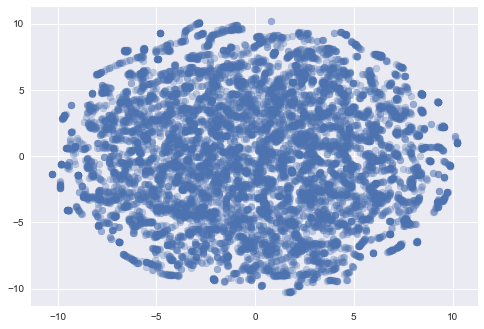

In [273]:
plt.scatter(T_tsne1[:, 0], T_tsne1[:, 1], alpha = .3)
plt.show()

Okay, so that took a long time and didn't really provide much information. I'll try again at a higher perplexity.

In [306]:
T_tsne2 = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=200).fit_transform(tops)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 10.025354
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.567701
[t-SNE] Error after 200 iterations: 1.567701


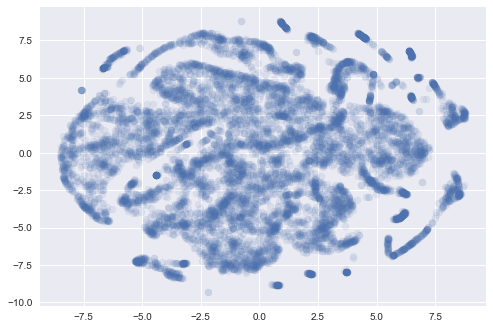

In [307]:
plt.scatter(T_tsne2[:, 0], T_tsne2[:, 1], alpha = .1)
plt.show()

Getting some more separation but not seeing anywhere near clearly defined clusters. I'll try with perplexity set to 50 and see if that reveals anything.

Any tuning suggestions you have for t-SNE parameters or modifications to df I'm feeding it would be greatly appreciated.

Also, would you suggest sampling a smaller portion of the df to run t-sne on? `tops` df I'm using above has about 10k obs and 55 features.

In [271]:
T_tsne3 = TSNE(n_components=2, perplexity=50, n_iter=200).fit_transform(tops)

## <center> UPDATED SECTION </center>
---


Okay, t-SNE on the tops df for 50 perplexity is complete. From the plot below, I can see some separation starting to occur between the cluster, but not the kind of neat, clear pattern I would have preferred to see.

I'll try tweaking the number of iterations to 1000 and 5000 across perplexities 5, 25, and 50. I'll repeat this same process for each of the remaining player position DF partitions, generating 9 t-SNE numpy 2D-arrays for each position, and 45 in total.

**NOTE**: I ended up storing each of the arrays in separate variables and so there's quite a bit of code, please feel free to skim ahead to the next heading. It definitely would be cleaner to generate the arrays through nested for loops modifying perplexity and iterations, then storing the results in a dictionary with the keys derived from the values of perplexity and n_iter, and when I clean up this code I'll do that. But on this first run I was more worried about not tying up the kernel for hours at a time as well as being able to run tsne with the verbose argument set to true so I could see what was going on in the algorithm.

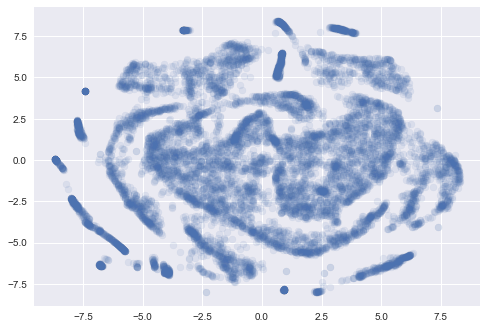

In [269]:
plt.scatter(T_tsne3[:, 0], T_tsne3[:, 1], alpha = .1)
plt.show()

In [ ]:
# Remaining Top lane t-SNE arrays.

T_tsne4 = TSNE(n_components=2, perplexity=5, n_iter=1000).fit_transform(tops)
T_tsne5 = TSNE(n_components=2, perplexity=25, n_iter=1000).fit_transform(tops)
T_tsne6 = TSNE(n_components=2, perplexity=50, n_iter=1000).fit_transform(tops)

In [158]:
T_tsne7 = TSNE(n_components=2, perplexity=5, n_iter=5000).fit_transform(tops)
T_tsne8 = TSNE(n_components=2, perplexity=25, n_iter=5000).fit_transform(tops)
T_tsne9 = TSNE(n_components=2, perplexity=50, n_iter=5000).fit_transform(tops)

In [267]:
# Jungle t-SNE arrays

jungs = vif_playerDF.loc[k_players.position == 'Jungle', regs]
J_tsne1 = TSNE(n_components=2, perplexity=5, n_iter=200).fit_transform(jungs)
J_tsne2 = TSNE(n_components=2, perplexity=50, n_iter=200).fit_transform(jungs)
J_tsne3 = TSNE(n_components=2, perplexity=25, n_iter=200).fit_transform(jungs)

In [265]:
J_tsne4 = TSNE(n_components=2, perplexity=5, n_iter=1000).fit_transform(jungs)
J_tsne5 = TSNE(n_components=2, perplexity=25, n_iter=1000).fit_transform(jungs)
J_tsne6 = TSNE(n_components=2, perplexity=50, n_iter=1000).fit_transform(jungs)

In [263]:
J_tsne7 = TSNE(n_components=2, perplexity=5, n_iter=5000).fit_transform(jungs)
J_tsne8 = TSNE(n_components=2, perplexity=25, n_iter=5000).fit_transform(jungs)
J_tsne9 = TSNE(n_components=2, perplexity=50, n_iter=5000).fit_transform(jungs)

In [261]:
# Mid lane t-SNE arrays

mids = vif_playerDF.loc[k_players.position == 'Middle', regs]
M_tsne1 = TSNE(n_components=2, perplexity=5, n_iter=200).fit_transform(mids)
M_tsne2 = TSNE(n_components=2, perplexity=25, n_iter=200).fit_transform(mids)
M_tsne3 = TSNE(n_components=2, perplexity=50, n_iter=200).fit_transform(mids)

In [259]:
M_tsne4 = TSNE(n_components=2, perplexity=5, n_iter=1000).fit_transform(mids)
M_tsne5 = TSNE(n_components=2, perplexity=25, n_iter=1000).fit_transform(mids)
M_tsne6 = TSNE(n_components=2, perplexity=50, n_iter=1000).fit_transform(mids)

In [258]:
M_tsne7 = TSNE(n_components=2, perplexity=5, n_iter=5000).fit_transform(mids)
M_tsne8 = TSNE(n_components=2, perplexity=25, n_iter=5000).fit_transform(mids)
M_tsne9 = TSNE(n_components=2, perplexity=50, n_iter=5000).fit_transform(mids)

In [115]:
# AD-Carry t-SNE arrays

adcs = vif_playerDF.loc[k_players.position == 'ADC', regs]

A_tsne1 = TSNE(n_components=2, perplexity=5, n_iter=200).fit_transform(adcs)
A_tsne2 = TSNE(n_components=2, perplexity=25, n_iter=200).fit_transform(adcs)
A_tsne3 = TSNE(n_components=2, perplexity=50, n_iter=200).fit_transform(adcs)

In [116]:
A_tsne4 = TSNE(n_components=2, perplexity=5, n_iter=1000).fit_transform(adcs)
A_tsne5 = TSNE(n_components=2, perplexity=25, n_iter=1000).fit_transform(adcs)
A_tsne6 = TSNE(n_components=2, perplexity=50, n_iter=1000).fit_transform(adcs)

In [117]:
A_tsne7 = TSNE(n_components=2, perplexity=5, n_iter=5000).fit_transform(adcs)
A_tsne8 = TSNE(n_components=2, perplexity=25, n_iter=5000).fit_transform(adcs)
A_tsne9 = TSNE(n_components=2, perplexity=50, n_iter=5000).fit_transform(adcs)

In [118]:
# Support t-SNE arrays

sups = vif_playerDF.loc[k_players.position == 'Support', regs]

S_tsne1 = TSNE(n_components=2, perplexity=5, n_iter=200).fit_transform(sups)
S_tsne2 = TSNE(n_components=2, perplexity=25, n_iter=200).fit_transform(sups)
S_tsne3 = TSNE(n_components=2, perplexity=50, n_iter=200).fit_transform(sups)

In [119]:
S_tsne4 = TSNE(n_components=2, perplexity=5, n_iter=1000).fit_transform(sups)
S_tsne5 = TSNE(n_components=2, perplexity=25, n_iter=1000).fit_transform(sups)
S_tsne6 = TSNE(n_components=2, perplexity=50, n_iter=1000).fit_transform(sups)

In [120]:
S_tsne7 = TSNE(n_components=2, perplexity=5, n_iter=5000).fit_transform(sups)
S_tsne8 = TSNE(n_components=2, perplexity=25, n_iter=5000).fit_transform(sups)
S_tsne9 = TSNE(n_components=2, perplexity=50, n_iter=5000).fit_transform(sups)

## t-SNE Visualization (cont'd)
---

Now that I have all the numpy arrays generated, I can finally start to examine the dimensionality reduction for patterns, as well as test the validity of my original k-means clustering.

To avoid large blocks of plotting code, I've functionalized a grid plotting scheme below, which takes the position title (ie 'Junglers', 'ADCs') and root name of the numpy arrays to plot ('T_tsne', 'J_tsne', etc) as required arguments, as well as original clustering labels for position being plotted, a colormap choice, and alpha as optional arguments. It then plots a 3 by 3 grid of the corresponding arrays.

In [299]:
def plot_tsne_grid(pos, root ,a = .5, labs = None, col_map = 'Set1'):
    
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(10,10))
    f.suptitle('t-SNE Dimensionality Reduction for ' + pos)

    for i in range(1,10):
        data = eval(root + str(i))
        eval('ax'+str(i)).scatter(data[:, 0], data[:, 1], c = labs, cmap = plt.cm.get_cmap(col_map, 5), alpha = a)
        eval('ax'+str(i)).set_yticklabels([])
        eval('ax'+str(i)).set_xticklabels([])
 
    ax1.set_ylabel('$Perplexity = 5$')
    ax4.set_ylabel('$Perplexity = 25$')
    ax7.set_ylabel('$Perplexity = 50$')
    ax7.set_xlabel('$Max Steps = 200$')
    ax8.set_xlabel('$Max Steps = 1000$')
    ax9.set_xlabel('$Max Steps = 5000$')    
    plt.subplots_adjust(left=.01, bottom=.01, right=.99, top=.95, wspace=.04, hspace=.04)
    plt.show()

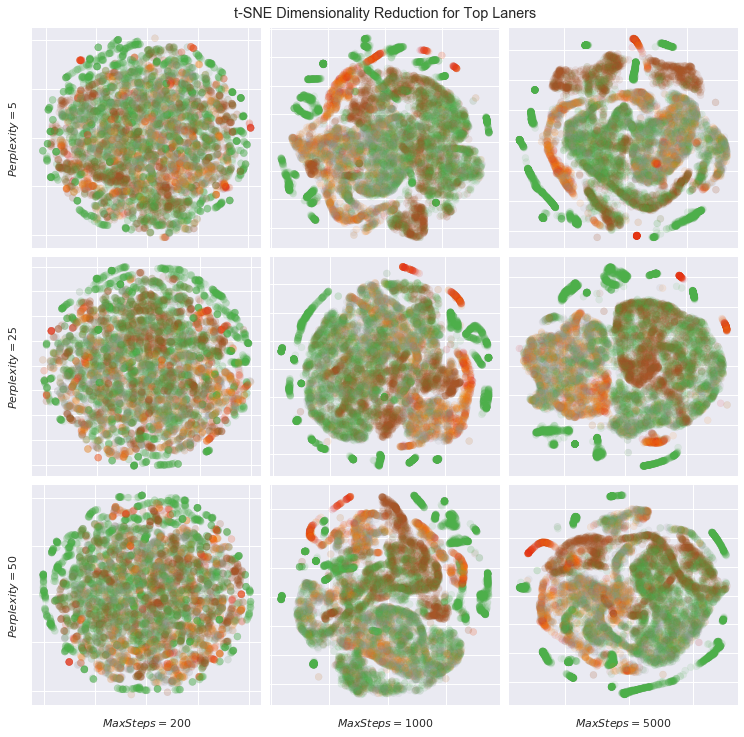

In [301]:
plot_tsne_grid('Top Laners', 'T_tsne', .1,first_clustDFs[0].cluster, 'Set1')

This is definitley not the pretty picture I was hoping for. While there is some separation occuring among the clusters as the max iterations and perplexity increase, there is not a clear pattern, and furthmore the original clusters do not appear to have been assigned in a particularly meaningful manner. I does seem from the 50 perplexity 1k and 5k arrays, as well as the 25 perplexity 5k, that there might only be 3 meaningful clusters forming, but it's hard to say.

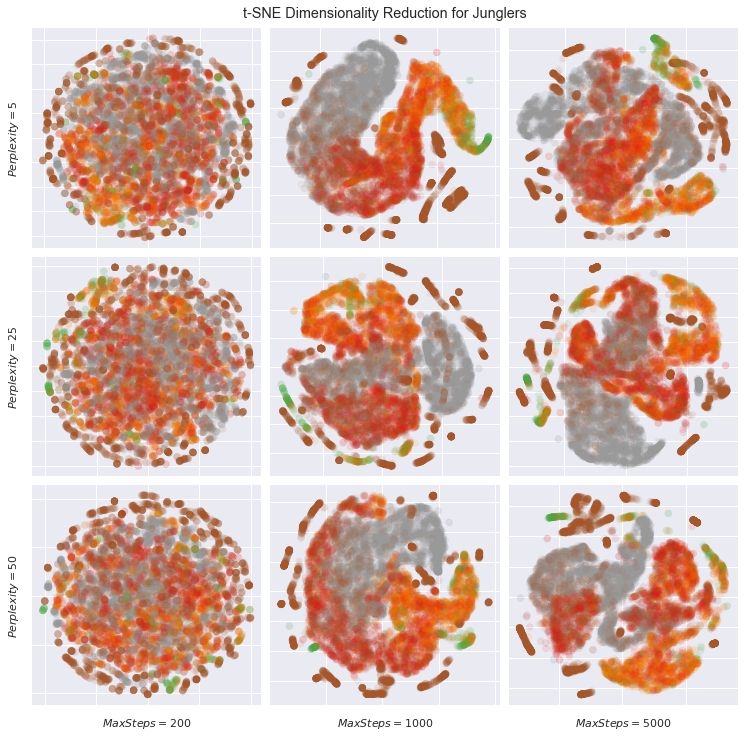

In [302]:
plot_tsne_grid('Junglers', 'J_tsne', .1,first_clustDFs[1].cluster, 'Set1')

This set of images is a bit more readable than the ones for the top laners. While none of these reveal perfect separation, all of the images besides the 200 iteration ones show more sensible though not perfect representation of the original labels. I think there are 4 natural(ish) clusters in this partition of the DF.

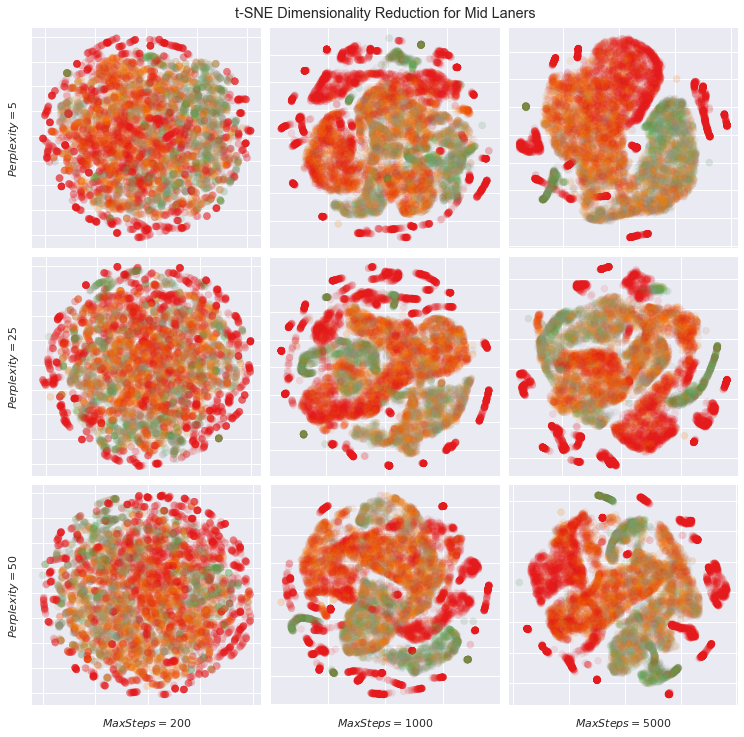

In [303]:
plot_tsne_grid('Mid Laners', 'M_tsne', .1,first_clustDFs[2].cluster, 'Set1')

The mid lane is a straight up mess, and this makes sense within the domain knowledge. Mid lane is one of the most flexible positions in terms of the types of champions that can be played there. Control mages, ap assassins, ad assassins, marksmen, support, and tanks have all had their moments in the meta for the mid-lane, and that doesn't even consider the various hybrid variations of the aforementioned.

Perplexity 5 with 5k iterations suggests there might be a way to generalize the partition to 2 clusters if nothing better can be determined.

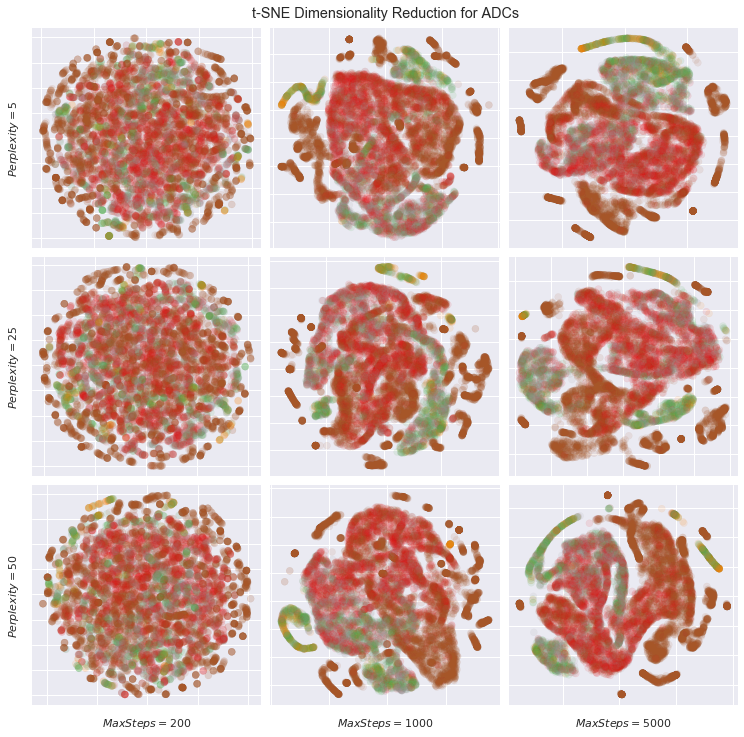

In [304]:
plot_tsne_grid('ADCs', 'A_tsne', .1,first_clustDFs[3].cluster, 'Set1')

This set of plots is also fairly difficult to interpret. Going in, I would have expected AD carry to be the position with the least variation in playstyle, and certainly there is less clustering occuring than in the mid-laner plots, but from the 5k iteration column it looks like there are 3 or 4 clusters are appearing.

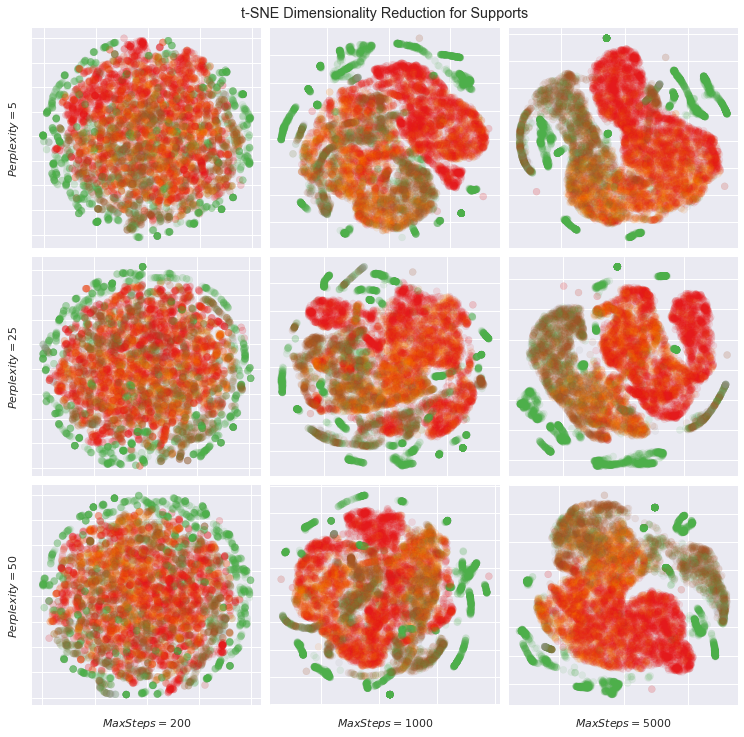

In [305]:
plot_tsne_grid('Supports', 'S_tsne', .1,first_clustDFs[4].cluster, 'Set1')

Also difficult to say from these plots, but I would approximate 3 or 4 clusters for this as well.

The perplexity 5 and 5k iteration plot is interesting. Before the observations start to move around at higher perplexities, it appears as if there 2 super clusters. If this were the case it might be representing the difference between melee and ranged supports. There would be sensible clustering in the features to support that possibility. For instance ranged supports would have lower ward clear rates than their melee counterparts but often higher damage share.

The perplexity 25 and 5k iteration plot might further on this theory, where it looks like there are 3 main clusters and a bunch of outliers. The red label cluster is split between 2 of those more natural clusters, which I'd venture a guess is maybe a difference between ranged offensive supports and ranged defensive supports.

## Turn it up to 11!

Since I still haven't been able to clearly identify the proper number of clusters for each position, I thought I might see what happens if I raise perplexity beyond 50 (the recommended threshold). From my understanding, this is something you're not supposed to do because t-SNE can behave erratically at perplexities greater than 50. But since I don't have a really strong idea of all the ideal cluster numbers from the previous plots, I don't have much to lose in trying this. I will however take these results with a grain of salt and not act on them unless they appear to confirm theories/suspicions from the previous plots.

Let's try perplexity set to 70.

In [308]:
T_tsne10 = TSNE(n_components=2, perplexity=70, n_iter=5000).fit_transform(tops)

In [310]:
J_tsne10 = TSNE(n_components=2, perplexity=70, n_iter=5000).fit_transform(jungs)

In [311]:
M_tsne10 = TSNE(n_components=2, perplexity=70, n_iter=5000).fit_transform(mids)

In [312]:
A_tsne10 = TSNE(n_components=2, perplexity=70, n_iter=5000).fit_transform(adcs)

In [313]:
S_tsne10 = TSNE(n_components=2, perplexity=70, n_iter=5000).fit_transform(sups)

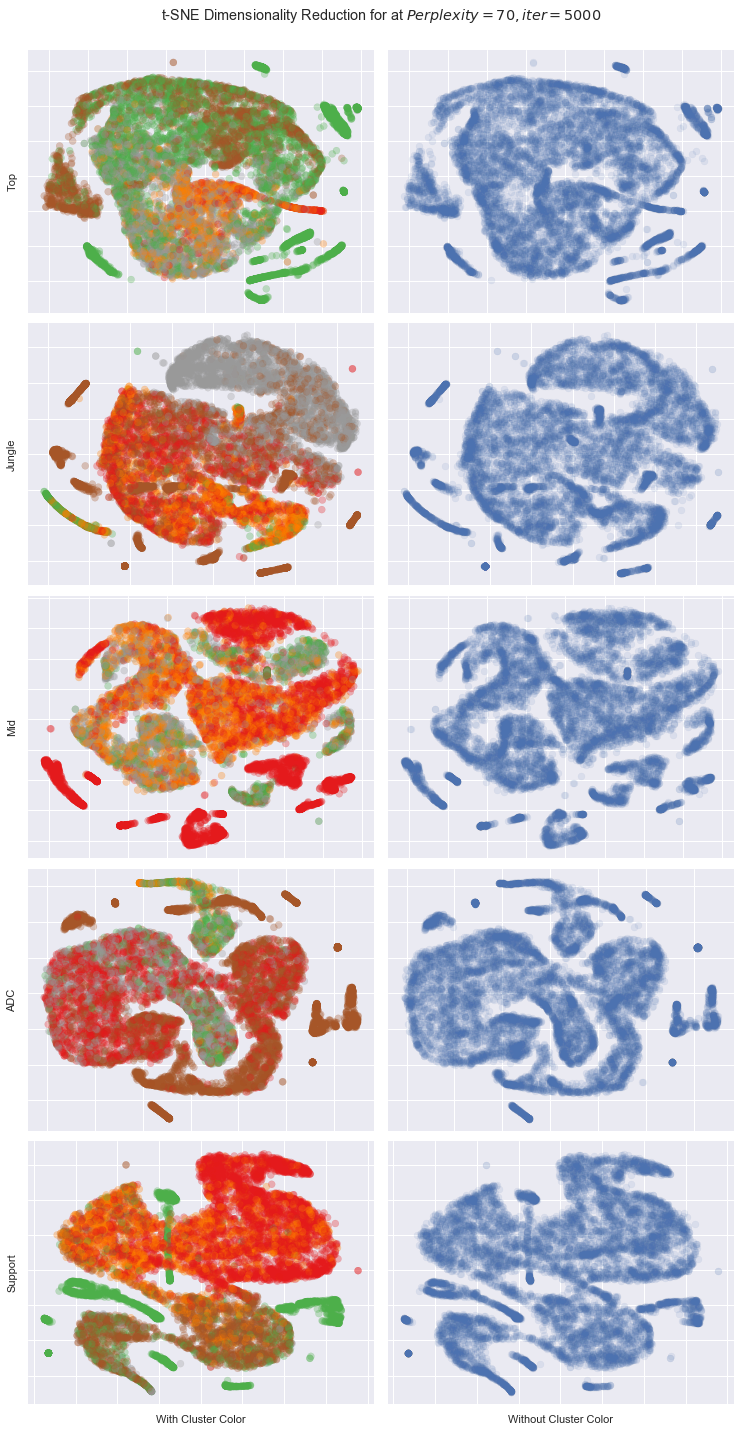

In [331]:
f, ((ax1, ax6), (ax2, ax7), (ax3, ax8), (ax4, ax9), (ax5, ax10)) = plt.subplots(5, 2, figsize=(10,20))
f.suptitle('t-SNE Dimensionality Reduction for at $Perplexity = 70, iter = 5000$')

for i, l in enumerate(['T', 'J', 'M', 'A', 'S']):
    data = eval(l + '_tsne10')
    eval('ax'+str(i+1)).scatter(data[:, 0], data[:, 1], c = first_clustDFs[i].cluster,
                                cmap = plt.cm.get_cmap('Set1', 5), alpha = .3)
    eval('ax'+str(i+1)).set_yticklabels([])
    eval('ax'+str(i+1)).set_xticklabels([])
           
    eval('ax'+str(i+6)).scatter(data[:, 0], data[:, 1], alpha = .1)
    eval('ax'+str(i+6)).set_yticklabels([])
    eval('ax'+str(i+6)).set_xticklabels([])

ax1.set_ylabel('Top')
ax2.set_ylabel('Jungle')
ax3.set_ylabel('Mid')
ax4.set_ylabel('ADC')
ax5.set_ylabel('Support')
ax5.set_xlabel('With Cluster Color')
ax10.set_xlabel('Without Cluster Color')
plt.subplots_adjust(left=.01, bottom=.01, right=.99, top=.95, wspace=.04, hspace=.04)
plt.show()

This doesn't appear to have helped much with the top, jungle, and mid figures (although it looks like there might be 6 mid-lane clusters).

However, there are some clearer patterns starting to emerge on the ADC and Support data. It looks like there are roughly 3 adc clusters and 3 or 4 support. 3 ADC types is in line with what I might have suspected from the earlier plots. 4 supports is not something that really looked likely in the previous plots, but 3 did.

Maybe if I brought perplexity down closer to the threshold I might see something clearer. I'll repeat the previous set of operations with 60 perplexity.

In [314]:
T_tsne11 = TSNE(n_components=2, perplexity=60, n_iter=5000).fit_transform(tops)

In [315]:
J_tsne11 = TSNE(n_components=2, perplexity=60, n_iter=5000).fit_transform(jungs)

In [316]:
M_tsne11 = TSNE(n_components=2, perplexity=60, n_iter=5000).fit_transform(mids)

In [317]:
A_tsne11 = TSNE(n_components=2, perplexity=60, n_iter=5000).fit_transform(adcs)

In [333]:
S_tsne11 = TSNE(n_components=2, perplexity=60, n_iter=5000).fit_transform(sups)

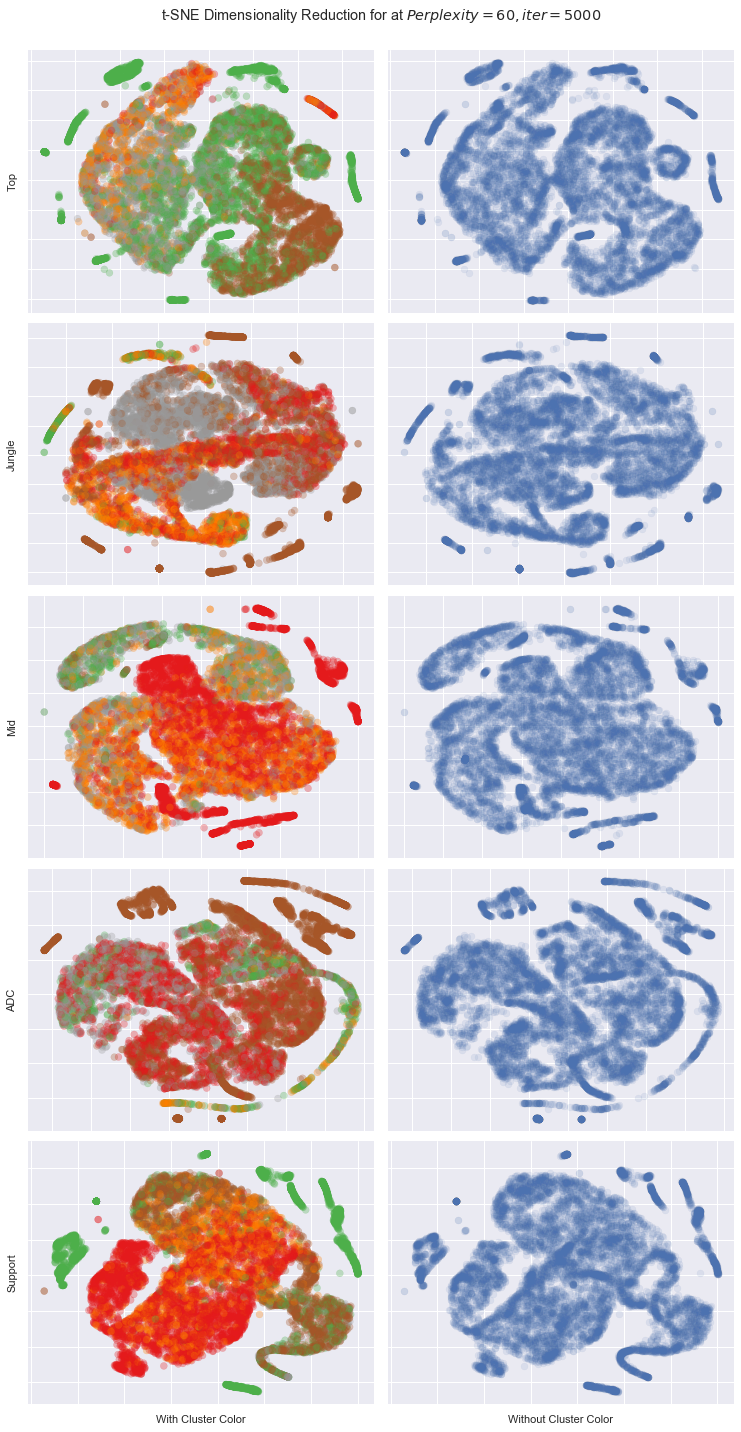

In [336]:
f, ((ax1, ax6), (ax2, ax7), (ax3, ax8), (ax4, ax9), (ax5, ax10)) = plt.subplots(5, 2, figsize=(10,20))
f.suptitle('t-SNE Dimensionality Reduction for at $Perplexity = 60, iter = 5000$')

for i, l in enumerate(['T', 'J', 'M', 'A', 'S']):
    data = eval(l + '_tsne11')
    eval('ax'+str(i+1)).scatter(data[:, 0], data[:, 1], c = first_clustDFs[i].cluster,
                                cmap = plt.cm.get_cmap('Set1', 5), alpha = .3)
    eval('ax'+str(i+1)).set_yticklabels([])
    eval('ax'+str(i+1)).set_xticklabels([])
           
    eval('ax'+str(i+6)).scatter(data[:, 0], data[:, 1], alpha = .1)
    eval('ax'+str(i+6)).set_yticklabels([])
    eval('ax'+str(i+6)).set_xticklabels([])

ax1.set_ylabel('Top')
ax2.set_ylabel('Jungle')
ax3.set_ylabel('Mid')
ax4.set_ylabel('ADC')
ax5.set_ylabel('Support')
ax5.set_xlabel('With Cluster Color')
ax10.set_xlabel('Without Cluster Color')
plt.subplots_adjust(left=.01, bottom=.01, right=.99, top=.95, wspace=.04, hspace=.04)
plt.show()

This set of plots seems to offer even less insight. It looks like maybe there are 2 super groups for top laners (tanks and split-pushers), but that's about it.

---

## Questions for Alex:

I'm definitely getting to the point where my understanding of exactly what's going on and what to do is being stretched. My next steps will be to use the information I've inferred here to determine how many clusters I should attempt to divide each position into, use the helper function I wrote earlier in this notebook to interpret what each of the clusters represent to come up with more meaningful labels, then to use those new clusters towards doing a logistic regression on the teamDF as before but this time being more able to understand what those new categoricals mean. From there I'd probably make a list of combinations for the possible team compositions of the newly derived position types, and see which combinations had the highest win percentage. From there, I would like to run another round of t-SNE and k-means clustering on the aggregate team data with those new position types as dummy variables, in order to put the observations into playstyle bins. The problem though, is that if I have those dummy variables in the DF, along with the existing variables, I might be running t-SNE on something with 10k obs and 80 features, which I read is more features than should be used in the algorithm.

So the questions I have are this:

- Are the steps I've taken (and plan to take) sensible to you or have I gotten way off track somewhere?
- Are my interpretations of these t-SNE plots valid(ish) or have I missed something egregious?
- I realize that this is real world data and won't cluster as neatly as something like the iris dataset, but do you think I can improve upon my current results? Do you have any tuning suggestions for improving the t-SNE operations I've done? Would you change any parameters? Add PCA initialization argument to it? Reduce the number of features I'm feeding it or reduce observations (playerDF partitions I'm using are about 10k obs with 55 vars each)?
- More specifically on the question of reducing the number of features. I noticed near the end of this update that there are features included that might reflect the success (or lack there of) a player/team is already experiencing in the game (deaths, tower kills, first blood, etc). I know I want to eliminate things like this from going into the k-means clustering decision, because I don't want my position type clusters to reflect winning and losing in any way. Should I repeat my t-SNE operations with things like that removed or simply remove them from the data fed to k-means in the next step? Is it possible that by having features like this in the t-SNE arrays the algorithm unintentionally started to break what would have been natural clusters in two? For example, rather than split top-lane into 2 clusters for tanks and split-pushers (if hypothetically those were the only 2 playstyles that existed for top-lane), the algorithm instead unknowingly split them into 4 clusters: winning tank, losing tank, winning split-pusher, losing split-pusher. While I certainly don't want to have to rerun all of the code in this notebook, I also don't want to use a biased interpretation of the data to inform the number of clusters I assign to each position.
- Anything else I haven't thought of?